# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

### Team 30
- A01796272 - Luis Antonio Ramirez Martinez
- A01796323 - Benjamin Cisneros Barraza
- A01796363 - Arthur Jafed Zizumbo Velasco
- A01796937 - Sandra Luz Cervantes Espinoza

## Convolutional Neural Networks  

### Activity 2c: Exploring Transfer Learning with CIFAR-10


- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.




In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

In [22]:
import matplotlib.pyplot as plt

#### CIFAR-10 Data Preparation: Transforms and DataLoaders (High‑Level Overview)

**Goal**  
Prepare CIFAR-10 for deep learning experiments by defining preprocessing transforms, creating dataset objects, and exposing DataLoaders for training, validation, and testing.

**Why two transforms?**  
- `transform_imagenet` resizes to **224×224** and applies **ImageNet normalization**. This matches the expected input distribution of **ImageNet-pretrained models** (e.g., ResNet, ViT), which typically accelerates convergence and improves accuracy when fine-tuning.  
- `transform_cifar` (kept as an alternative) preserves the native **32×32** resolution and uses **CIFAR-10 statistics**. Prefer this when training **from scratch** on CIFAR-sized architectures to avoid unnecessary upscaling and to reduce compute.

**Splitting strategy**  
CIFAR-10 provides **50,000 training** and **10,000 test** images. The code performs an **in-place train/val split** from the 50k training partition using `SubsetRandomSampler`:
- **Training:** first `NUM_TRAIN` samples (default **45,000**).  
- **Validation:** remaining **5,000**.  
This approach avoids duplicating or altering the dataset object while ensuring random sampling within defined index ranges.

**Batching and steps per epoch**  
A single `MINIBATCH_SIZE` is used for all splits to keep throughput consistent. The script computes and prints **steps per epoch** (ceil division) for each split, helping you verify expected loop lengths in your training code.

**Labeled print summaries**  
At runtime, the script logs:
- Dataset directory path  
- Train/Val/Test counts  
- Batch size  
- Steps per epoch (Train/Val/Test)  
- Active transform configuration (resize and normalization)  

These checks provide quick validation of the data pipeline (paths, splits, and preprocessing) before launching long training runs.

In [23]:
# -----------------------------------------------------------------------------
# Configuration: paths, dataset sizes, and preprocessing pipelines
# -----------------------------------------------------------------------------

# Local path to the CIFAR-10 dataset (pre-downloaded or auto-downloaded here).
# You can swap to the commented line below if you store the dataset elsewhere.
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/cifar-10/cifar-10-batches-py'
DATA_PATH = './data/cifar-10-batches-py'

# Number of samples used for the training split (from CIFAR-10's 50k train set).
# The remaining (50k - NUM_TRAIN) will be used as a validation split.
NUM_TRAIN = 45000

# Number of images per mini-batch for all DataLoaders.
MINIBATCH_SIZE = 64

# -----------------------------------------------------------------------------
# Transforms (preprocessing & normalization)
# -----------------------------------------------------------------------------
# Note:
# - transform_imagenet resizes images to 224x224 and normalizes using ImageNet statistics.
#   This is typically used when training or fine-tuning models pretrained on ImageNet.
# - transform_cifar normalizes using CIFAR-10 channel statistics and keeps native size (32x32).
#   It is provided here as an alternative if you prefer staying at CIFAR resolution.
transform_imagenet = T.Compose([
    T.Resize(224),                                        # Upscale CIFAR-10 (32x32) to 224x224
    T.ToTensor(),                                         # Convert PIL Image to tensor [0, 1]
    T.Normalize((0.485, 0.456, 0.406),                    # ImageNet mean (per channel)
                (0.229, 0.224, 0.225))                    # ImageNet std  (per channel)
])

transform_cifar = T.Compose([
    T.ToTensor(),                                         # Convert PIL Image to tensor [0, 1]
    T.Normalize([0.491, 0.482, 0.447],                    # CIFAR-10 mean (per channel)
                [0.247, 0.243, 0.261])                    # CIFAR-10 std  (per channel)
])

# -----------------------------------------------------------------------------
# Datasets & DataLoaders
# -----------------------------------------------------------------------------
# We create three DataLoaders: train, validation, and test.
# The train/val split is created from the official training set (50,000 images)
# by slicing with SubsetRandomSampler so the dataset object remains unchanged.
# -----------------------------------------------------------------------------

# Training set loader (first NUM_TRAIN samples from the 50k train split)
cifar10_train = datasets.CIFAR10(
    DATA_PATH,
    train=True,
    download=True,
    transform=transform_imagenet
)
train_loader = DataLoader(
    cifar10_train,
    batch_size=MINIBATCH_SIZE,
    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN))  # [0, NUM_TRAIN)
)

# Validation set loader (remaining samples from the 50k train split)
cifar10_val = datasets.CIFAR10(
    DATA_PATH,
    train=True,
    download=True,
    transform=transform_imagenet
)
val_loader = DataLoader(
    cifar10_val,
    batch_size=MINIBATCH_SIZE,
    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val)))  # [NUM_TRAIN, 50000)
)

# Testing set loader (official 10,000-image test split)
cifar10_test = datasets.CIFAR10(
    DATA_PATH,
    train=False,
    download=True,
    transform=transform_imagenet
)
test_loader = DataLoader(
    cifar10_test,
    batch_size=MINIBATCH_SIZE
)

# -----------------------------------------------------------------------------
# Helpful, labeled prints (dataset sizes and steps per epoch)
# -----------------------------------------------------------------------------
# These prints summarize splits and effective number of steps per epoch, which helps
# validate the pipeline quickly when you run the script.
import math

num_train_total = len(cifar10_train)          # Should be 50,000
num_val = len(cifar10_val) - NUM_TRAIN        # Computed from sampler slice
num_test = len(cifar10_test)                  # Should be 10,000

# Steps per epoch (ceil division) for quick sanity check
train_steps = math.ceil(NUM_TRAIN / MINIBATCH_SIZE)
val_steps = math.ceil(num_val / MINIBATCH_SIZE)
test_steps = math.ceil(num_test / MINIBATCH_SIZE)

print("=== CIFAR-10 Data Summary ===")
print(f"[Path] Dataset directory           : {DATA_PATH}")
print(f"[Counts] Train / Val / Test        : {NUM_TRAIN:,} / {num_val:,} / {num_test:,}")
print(f"[Batch] Minibatch size             : {MINIBATCH_SIZE}")
print(f"[Steps/Epoch] Train / Val / Test   : {train_steps} / {val_steps} / {test_steps}")
print("[Transforms] Using ImageNet normalization (μ=[0.485,0.456,0.406], σ=[0.229,0.224,0.225]) "
      "with Resize(224) for all splits.")

=== CIFAR-10 Data Summary ===
[Path] Dataset directory           : ./data/cifar-10-batches-py
[Counts] Train / Val / Test        : 45,000 / 5,000 / 10,000
[Batch] Minibatch size             : 64
[Steps/Epoch] Train / Val / Test   : 704 / 79 / 157
[Transforms] Using ImageNet normalization (μ=[0.485,0.456,0.406], σ=[0.229,0.224,0.225]) with Resize(224) for all splits.


In [24]:
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 224, 224]) torch.Size([64])
1 torch.Size([64, 3, 224, 224]) torch.Size([64])
2 torch.Size([64, 3, 224, 224]) torch.Size([64])
3 torch.Size([64, 3, 224, 224]) torch.Size([64])
4 torch.Size([64, 3, 224, 224]) torch.Size([64])
5 torch.Size([64, 3, 224, 224]) torch.Size([64])
6 torch.Size([64, 3, 224, 224]) torch.Size([64])
7 torch.Size([64, 3, 224, 224]) torch.Size([64])
8 torch.Size([64, 3, 224, 224]) torch.Size([64])
9 torch.Size([64, 3, 224, 224]) torch.Size([64])
10 torch.Size([64, 3, 224, 224]) torch.Size([64])
11 torch.Size([64, 3, 224, 224]) torch.Size([64])
12 torch.Size([64, 3, 224, 224]) torch.Size([64])
13 torch.Size([64, 3, 224, 224]) torch.Size([64])
14 torch.Size([64, 3, 224, 224]) torch.Size([64])
15 torch.Size([64, 3, 224, 224]) torch.Size([64])
16 torch.Size([64, 3, 224, 224]) torch.Size([64])
17 torch.Size([64, 3, 224, 224]) torch.Size([64])
18 torch.Size([64, 3, 224, 224]) torch.Size([64])
19 torch.Size([64, 3, 224, 224]) torch.Size([64])
20 torch.S

#### Device Selection Logic for Deep Learning Training

**Purpose**  
This block determines the best available hardware device for running deep learning computations. Efficient device selection can significantly improve training performance, especially when GPUs or specialized accelerators are available.

**Key Steps Explained**

1. **CUDA Check (Highest Priority)**  
   The script first checks `torch.cuda.is_available()` to determine if an NVIDIA GPU with CUDA support is accessible.  
   - CUDA provides massive parallelism and is the fastest option for PyTorch training on compatible systems.
   - If available, the device is set to `"cuda"`.

2. **Apple MPS Check (Secondary Option)**  
   If CUDA is not available, the code checks whether Apple’s Metal Performance Shaders (MPS) backend is available and built using:
   ```python
   torch.backends.mps.is_available()
   torch.backends.mps.is_built()
   ```
   - MPS is optimized for Apple Silicon (M1, M2, M3 chips) and accelerates training on macOS.
   - If supported, the device is set to "mps".

3. CPU Fallback (Default)
  If neither CUDA nor MPS is supported, the system defaults to CPU, ensuring training can still proceed:
   ```python
   device = torch.device('cpu')
   ```
4. Labeled Output
   A clear print statement is included:
   ```
   [INFO] Selected device for computation: <device>
   ```
This helps confirm which hardware backend the model will use before training begins.


**Why this logic is important**

- Automatically selects the *best-performing* hardware without requiring manual configuration.
- Ensures compatibility across Windows, Linux, and macOS systems.
- Provides transparency and easy debugging through well-labeled output.

This structure makes the code portable, user‑friendly, and efficient for real deep‑learning environments.



In [25]:
# -----------------------------------------------------------------------------
# Device Selection Logic
# -----------------------------------------------------------------------------
# This section checks the available hardware acceleration options in order:
#   1. NVIDIA CUDA (GPU support)
#   2. Apple MPS (Metal Performance Shaders for Apple Silicon)
#   3. CPU fallback
# -----------------------------------------------------------------------------

# Check if CUDA is available (NVIDIA GPU acceleration)
if torch.cuda.is_available():
    device = torch.device('cuda')   # Use CUDA-capable GPU

# If CUDA is not available, check for Apple's MPS backend (used on Apple Silicon)
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')    # Use MPS for accelerated training on macOS

# If neither CUDA nor MPS is available, fall back to CPU
else:
    device = torch.device('cpu')    # Use standard CPU execution

# Print the selected device with a clear label
print(f"[INFO] Selected device for computation: {device}")

[INFO] Selected device for computation: mps


#### Visualizing Random Test Samples from CIFAR‑10

**Purpose**  
This block of code selects and visualizes a random image from the CIFAR‑10 test set. Visual inspection is a useful step in machine learning workflows to confirm that data loading, preprocessing, and transformations (such as normalization) are functioning correctly.

---

##### Key Components Explained

**1. Class List (`classes`)**  
The list contains the human‑readable labels for CIFAR‑10’s ten categories.  
This allows converting numerical labels (0–9) into descriptive class names such as `"Plane"` or `"Dog"`.

---

**2. `plot_figure(image)` Function**  
This helper function:  
- Converts the image tensor from **CHW** (channels‑first) to **HWC** (channels‑last), which is required by Matplotlib.  
- Removes axis markings for a clean, image‑only visualization.  
- Displays the image using `plt.imshow`.

This abstraction keeps the main code clean and reusable.

---

**3. Random Test Sample Selection**  
A random index is generated using NumPy:
```python
np.random.randint(len(test_loader))
```

This ensures any image from the test dataset has an equal chance of being displayed.

The label is extracted from the dataset and mapped to the corresponding text description using the `classes` list.
A labeled print statement is used for clarity:
```
[INFO] Random sample corresponds to class: Cat
```

**4. Image Rescaling for Display**
Images may be normalized (e.g., mean‑std normalization), making pixel values negative or greater than 1.
To correctly visualize them, the code rescales the tensor to the range **[0,1]**:
```
(image - image.min()) / (image.max() - image.min())
```
This ensures consistent brightness and color representation.

**5. Displaying the Image**
Finally, the `plot_figure` function is called to show the selected image.
This final step provides a visual confirmation that the dataset is loaded and processed correctly.

**Why This Matters**

- Helps validate the accuracy of dataset loading.
- Confirms the correct functioning of preprocessing transforms.
- Useful for debugging or understanding how the model perceives input images.
- Encourages reproducibility and clarity in machine learning workflows.

This visualization step is often one of the first sanity checks before starting model training.

[INFO] Random sample corresponds to class: Bird


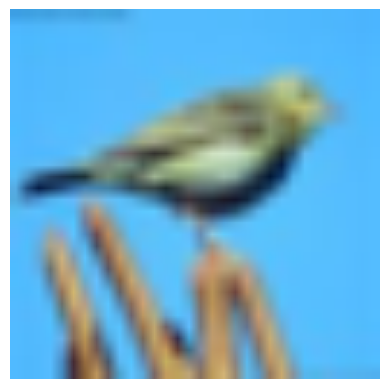

In [26]:
# -----------------------------------------------------------------------------
# Class labels for CIFAR‑10
# -----------------------------------------------------------------------------
# These correspond to the 10 categories in the CIFAR‑10 dataset.
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


# -----------------------------------------------------------------------------
# Utility function for plotting an image tensor
# -----------------------------------------------------------------------------
def plot_figure(image):
    """
    Display an image tensor using matplotlib.

    Parameters:
        image (Tensor): A 3D tensor representing an image in (C, H, W) format.
                        The function permutes it to (H, W, C) for plotting.
    """
    plt.imshow(image.permute(1, 2, 0))   # Convert from CHW → HWC for correct visualization
    plt.axis('off')                      # Hide axis ticks for a cleaner display
    plt.show()


# -----------------------------------------------------------------------------
# Sample a random image from the test set
# -----------------------------------------------------------------------------
rnd_sample_idx = np.random.randint(len(test_loader))  # Random index from test dataset

# Retrieve the class label of the sampled image
sample_label = test_loader.dataset[rnd_sample_idx][1]
print(f"[INFO] Random sample corresponds to class: {classes[sample_label]}")

# Retrieve the image tensor
image = test_loader.dataset[rnd_sample_idx][0]

# Normalize to [0,1] for visualization (some transforms make images negative)
image = (image - image.min()) / (image.max() - image.min())

# Display the image
plot_figure(image)


#### Computing Model Accuracy in PyTorch (High‑Level Overview)

**Purpose**  
This function evaluates how well a trained model performs by calculating its **classification accuracy** over a dataset (train, validation, or test). Accuracy is a key metric for understanding model performance in supervised learning.

---

##### Key Concepts and Steps

**1. Switching to Evaluation Mode**  
```python
model.eval()
```
Evaluation mode disables layers like **Dropout** and changes **BatchNorm** behavior so that inference is deterministic and consistent. This ensures accuracy is measured correctly.

**2. Disabling Gradient Computation**
```python
with torch.no_grad():
```
During evaluation, gradients are not needed.
Disabling them:

- Reduces memory usage
- Improves computation speed
- Prevents unintended gradient updates

This is standard practice for inference.

**3. Moving Data and Model to the Selected Device**
The model and input tensors are moved to whichever device was previously selected (CPU, CUDA, or MPS).
This ensures compatibility and avoids device mismatch errors.

**4. Forward Pass and Prediction Logic**
The model outputs a score vector for each class.
Using:
```python
scores.max(dim=1)
```
returns the index of the highest value, which corresponds to the predicted class.
This is a common method for obtaining predictions in multi‑class classification tasks.

**5. Accuracy Computation**
Correct predictions are counted using:
```python
(pred == yi).sum(
```
Accuracy is computed as:
```
correct predictions / total predictions
```
and returned as a floating‑point number between **0 and 1**, which can be multiplied by 100 for percentage accuracy.

**Why This Matters**

- It provides a simple, efficient, and reliable method to evaluate model performance.
- The function works with any PyTorch model and any DataLoader.
- It ensures correct inference settings (no gradients, eval mode).
- It serves as a reusable utility in training scripts, notebooks, and experiments.

This accuracy function is a foundational tool in any deep learning workflow using PyTorch.

In [27]:
# -----------------------------------------------------------------------------
# Function: accuracy(model, loader)
# -----------------------------------------------------------------------------
# Computes the classification accuracy of a model over a given DataLoader.
# The function loops over all batches, makes predictions, and measures how many
# labels were correctly predicted.
# -----------------------------------------------------------------------------

def accuracy(model, loader):
    num_correct = 0      # Counter for correct predictions
    num_total = 0        # Counter for total predictions

    model.eval()         # Set model to evaluation mode (disables dropout, etc.)
    model = model.to(device=device)  # Move model to selected device (CPU/GPU/MPS)

    # Disable gradient calculations for memory savings and faster inference
    with torch.no_grad():
        for (xi, yi) in loader:
            # Move batch to device and ensure correct data types
            xi = xi.to(device=device, dtype=torch.float32)  # Inputs: float tensor
            yi = yi.to(device=device, dtype=torch.long)     # Labels: integer tensor

            # Forward pass: compute raw model outputs (logits)
            scores = model(xi)  # Shape: (batch_size, 10)

            # Predicted class = index of the highest score per sample
            _, pred = scores.max(dim=1)  # Shape: (batch_size,)

            # Count how many predictions match the true labels
            num_correct += (pred == yi).sum()

            # Update total number of samples processed
            num_total += pred.size(0)

        # Return accuracy as a float -> correct_predictions / total_predictions
        return float(num_correct) / num_total

#### Loading a Pretrained ResNet‑18 Model

This line initializes a *ResNet‑18* model with *ImageNet‑pretrained weights*. Using `pretrained=True` provides a model that has already learned general visual features such as edges, shapes, and textures. This is valuable for **transfer learning**, because starting from a pretrained model typically improves accuracy and speeds up convergence compared to training from scratch. The model is ready for tasks such as feature extraction or fine‑tuning on a custom dataset.

In [28]:
# -----------------------------------------------------------------------------
# Load a pretrained ResNet‑18 model
# -----------------------------------------------------------------------------
# This loads the ResNet‑18 architecture with weights pretrained on ImageNet.
# Pretrained models are commonly used for transfer learning, as they already
# contain rich feature representations learned from large-scale data.
model_resnet18 = models.resnet18(pretrained=True)

# Informational print to confirm model loading
print("[INFO] Loaded pretrained ResNet-18 model successfully.")

[INFO] Loaded pretrained ResNet-18 model successfully.


#### Exploremos el modelo

In [29]:
for i, w in enumerate(model_resnet18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [30]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Building a Sequential Feature Extractor from ResNet‑18

This snippet creates an auxiliary model by collecting all elements returned by `model_resnet18.children()` and passing them into `nn.Sequential`. This effectively transforms the ResNet‑18 backbone into a sequential module, which is useful when extracting intermediate features or modifying the architecture for tasks such as transfer learning or custom classification heads. Displaying `model_aux` allows inspecting the structure to understand how the layers are organized.


In [31]:
# -----------------------------------------------------------------------------
# Extract all child layers of the pretrained ResNet‑18 model
# -----------------------------------------------------------------------------
# `model_resnet18.children()` returns an iterator over the sequential components
# of the ResNet‑18 architecture (e.g., conv layers, batch norms, residual blocks).
# Wrapping them inside `nn.Sequential` allows treating the entire backbone as a
# single sequential feature extractor.
model_aux = nn.Sequential(*list(model_resnet18.children()))

# Display the resulting sequential model structure for inspection
print("[INFO] Constructed auxiliary sequential model from ResNet-18 backbone:")
model_aux


[INFO] Constructed auxiliary sequential model from ResNet-18 backbone:


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

#### Creating a ResNet‑18 Feature Extractor

This code constructs a feature extractor by taking all components returned by `model_resnet18.children()` except the last one. The final element in a ResNet‑18 model is the fully connected classification layer, and removing it allows the network to output high‑level feature vectors instead of class logits. This is useful in transfer learning pipelines where a custom classifier or task‑specific head is added on top of pretrained features. The use of `nn.Sequential` enables treating the remaining layers as a unified module.

In [32]:
# -----------------------------------------------------------------------------
# Create a feature extractor by removing the final classification layer of ResNet‑18
# -----------------------------------------------------------------------------
# `model_resnet18.children()` returns all major blocks of the network, including:
#   - Initial convolution and batch norm
#   - Residual layers (layer1–layer4)
#   - Adaptive average pooling
#   - Final fully connected (FC) classification layer
#
# By slicing with `[:-1]`, we exclude the last FC layer so the model can be used
# purely as a feature extractor for transfer learning or custom classification.
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

# Print confirmation that the final layer was removed
print("[INFO] Built feature extractor (ResNet‑18 without final FC layer).")

[INFO] Built feature extractor (ResNet‑18 without final FC layer).


In [33]:
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [34]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

In [35]:
for i, parameter in enumerate(model_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False


#### Training Loop with Validation Accuracy (Concise Overview)
This function performs supervised training over multiple epochs. The model is placed on the selected device to leverage available acceleration. For each batch, it runs a forward pass to produce logits, computes cross-entropy loss using labels, and applies **backpropagation** with the provided optimizer to update parameters. After each epoch, it evaluates accuracy on the validation set to track generalization. The function uses `model.train()` during optimization steps and `accuracy(...)` (which internally sets the model to eval mode) for validation, ensuring correct behavior of layers like dropout and batch normalization. The labeled print statement summarizes epoch, loss, and validation accuracy for easy monitoring.

In [36]:
# -----------------------------------------------------------------------------
# Training loop for supervised classification
# -----------------------------------------------------------------------------
# Trains a model using cross-entropy loss and an optimizer over a number of epochs.
# It iterates over the global `train_loader`, performs forward and backward passes,
# and evaluates validation accuracy on `val_loader` after each epoch.
# -----------------------------------------------------------------------------

def train(model, optimiser, epochs=100):
    # Note: A scheduler could be added (commented below) without changing the signature.
    # def train(model, optimiser, scheduler = None, epochs=100):

    # Ensure the model is on the selected device (CPU / CUDA / MPS)
    model = model.to(device=device)

    for epoch in range(epochs):
        # Put the model in training mode at the start of each epoch
        # (enables dropout, batchnorm stats, etc.)
        for i, (xi, yi) in enumerate(train_loader):
            model.train()

            # Move batch to device and enforce correct dtypes
            xi = xi.to(device=device, dtype=torch.float32)  # inputs
            yi = yi.to(device=device, dtype=torch.long)     # integer class labels

            # Forward pass: compute logits for the current batch
            scores = model(xi)  # Shape: (batch_size, num_classes)

            # Compute cross-entropy classification loss
            cost = F.cross_entropy(input=scores, target=yi)

            # Backpropagation step
            optimiser.zero_grad()  # reset gradients to avoid accumulation
            cost.backward()        # compute gradients
            optimiser.step()       # update model parameters

        # After finishing all batches: evaluate on validation set
        acc = accuracy(model, val_loader)

        # Optional: step a learning rate scheduler (kept commented to preserve signature)
        # if epoch % 5 == 0:
        #     scheduler.step()

        # Labeled and formatted progress print per epoch
        print(
            f"[EPOCH] {epoch:03d} | "
            f"[Loss] {cost.item():.4f} | "
            f"[Val Acc] {acc:.4f}"
        )

#### Transfer Learning Model Definition and Hyperparameters

This section sets key hyperparameters such as learning rate and number of epochs, then builds a model using transfer learning. Instead of training from scratch, the code attaches a new classifier head to `model_aux`, which contains all layers of ResNet‑18 except the final fully connected layer. The feature extractor outputs a 512‑dimensional vector for each image, which is flattened and passed to a new linear layer producing 10 class logits for CIFAR‑10. This approach improves performance and speeds up training compared to training a model from raw pixel inputs. The Adam optimizer is selected for efficient and stable convergence.


In [37]:
# -----------------------------------------------------------------------------
# Hyperparameters
# -----------------------------------------------------------------------------
hidden1 = 256   # Size of the first hidden layer (unused here, kept for reference)
hidden  = 256   # Size of the second hidden layer (unused here, kept for reference)
lr = 5e-4       # Learning rate for the optimizer
epochs = 3      # Number of epochs for training

# -----------------------------------------------------------------------------
# Model definition (Transfer Learning setup)
# -----------------------------------------------------------------------------
# Instead of using a fully-connected network from scratch (commented out),
# this version uses `model_aux`, which contains the pretrained ResNet-18
# backbone without its final classification layer. This backbone outputs
# a feature vector of size 512 for each image.
#
# The new head consists of:
# - Flatten: converts the output from (batch, 512, 1, 1) to (batch, 512)
# - Linear: maps 512 features into 10 CIFAR-10 classes
model1 = nn.Sequential(
    model_aux,                              # Pretrained feature extractor
    nn.Flatten(),                            # Flatten feature tensor
    nn.Linear(in_features=512, out_features=10, bias=True)  # New classifier
)

# -----------------------------------------------------------------------------
# Optimizer
# -----------------------------------------------------------------------------
# Adam optimizer is used for its adaptive learning rates and fast convergence.
optimiser = torch.optim.Adam(
    model1.parameters(),
    lr=lr,
    betas=(0.9, 0.999)
)

# Training call (commented)
# train(model1, optimiser, epochs)


In [38]:
model1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [39]:
train(model1, optimiser, epochs)

[EPOCH] 000 | [Loss] 0.5397 | [Val Acc] 0.7798
[EPOCH] 001 | [Loss] 0.6319 | [Val Acc] 0.7960
[EPOCH] 002 | [Loss] 0.5893 | [Val Acc] 0.7978


In [40]:
accuracy(model1, test_loader)

0.7926